# *Traffic Sign Recognizer - CNN*

## Importing Required Libraries

In [16]:
import os
import traceback
import random

import numpy as np
import pandas as pd
import cv2

import matplotlib.pyplot as plt
from matplotlib.image import imread

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, schedules
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Dense, Dropout, Flatten 
from keras.models import Sequential

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import tensorflow as tf

tf.random.set_seed(42)
random.seed(42)
np.random.seed(42)

## Assigning Path for Dataset

In [17]:
data_dir = 'dataset'
train_path = 'dataset/Train'
test_path = 'dataset/Test'

# Resizing the images to 30x30x3
IMG_HEIGHT = 30
IMG_WIDTH = 30
channels = 3

## Finding Total Classes

In [18]:
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

43

In [19]:
# Label Overview
classes = { 0:'Speed limit 20',
            1:'Speed limit 30', 
            2:'Speed limit 50', 
            3:'Speed limit 60', 
            4:'Speed limit 70', 
            5:'Speed limit 80', 
            6:'End of speed limit 80', 
            7:'Speed limit 100', 
            8:'Speed limit 120', 
            9:'No passing', 
            10:'No passing for over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'> 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing > 3.5 tons' }

## Visualizing The Dataset

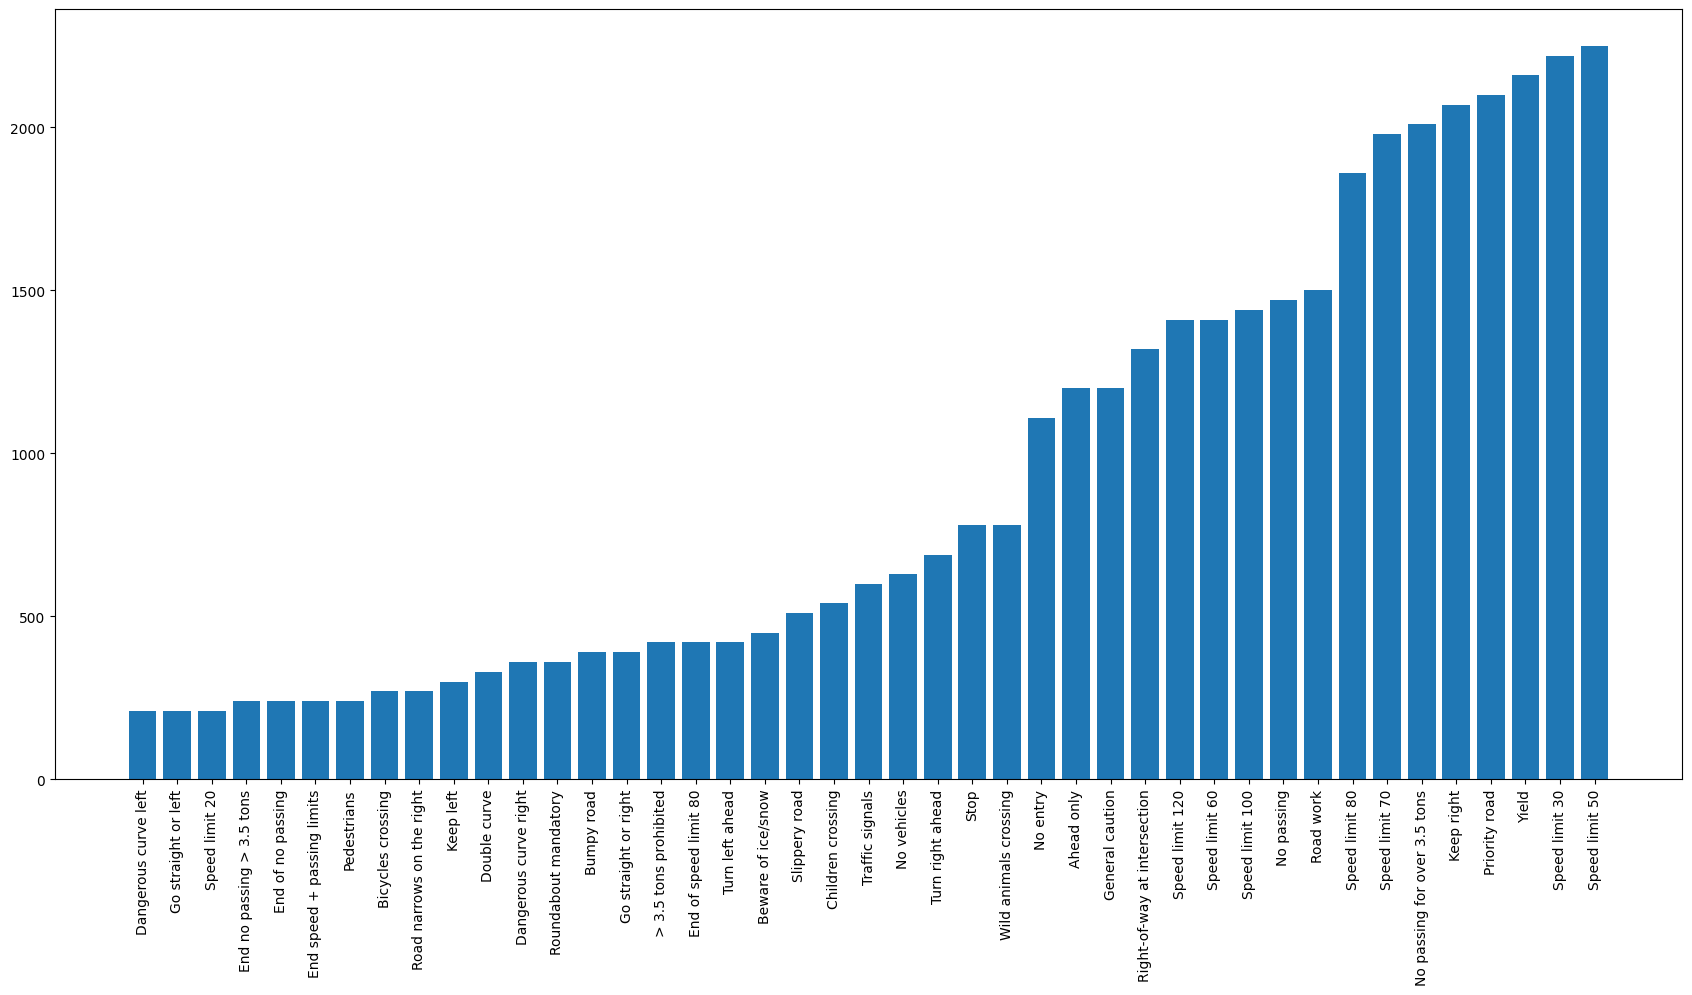

In [20]:
folders = os.listdir(train_path)

train_number = []
class_num = []
for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
plt.figure(figsize=(21,10))  
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

In [21]:
sum(train_number)

39209

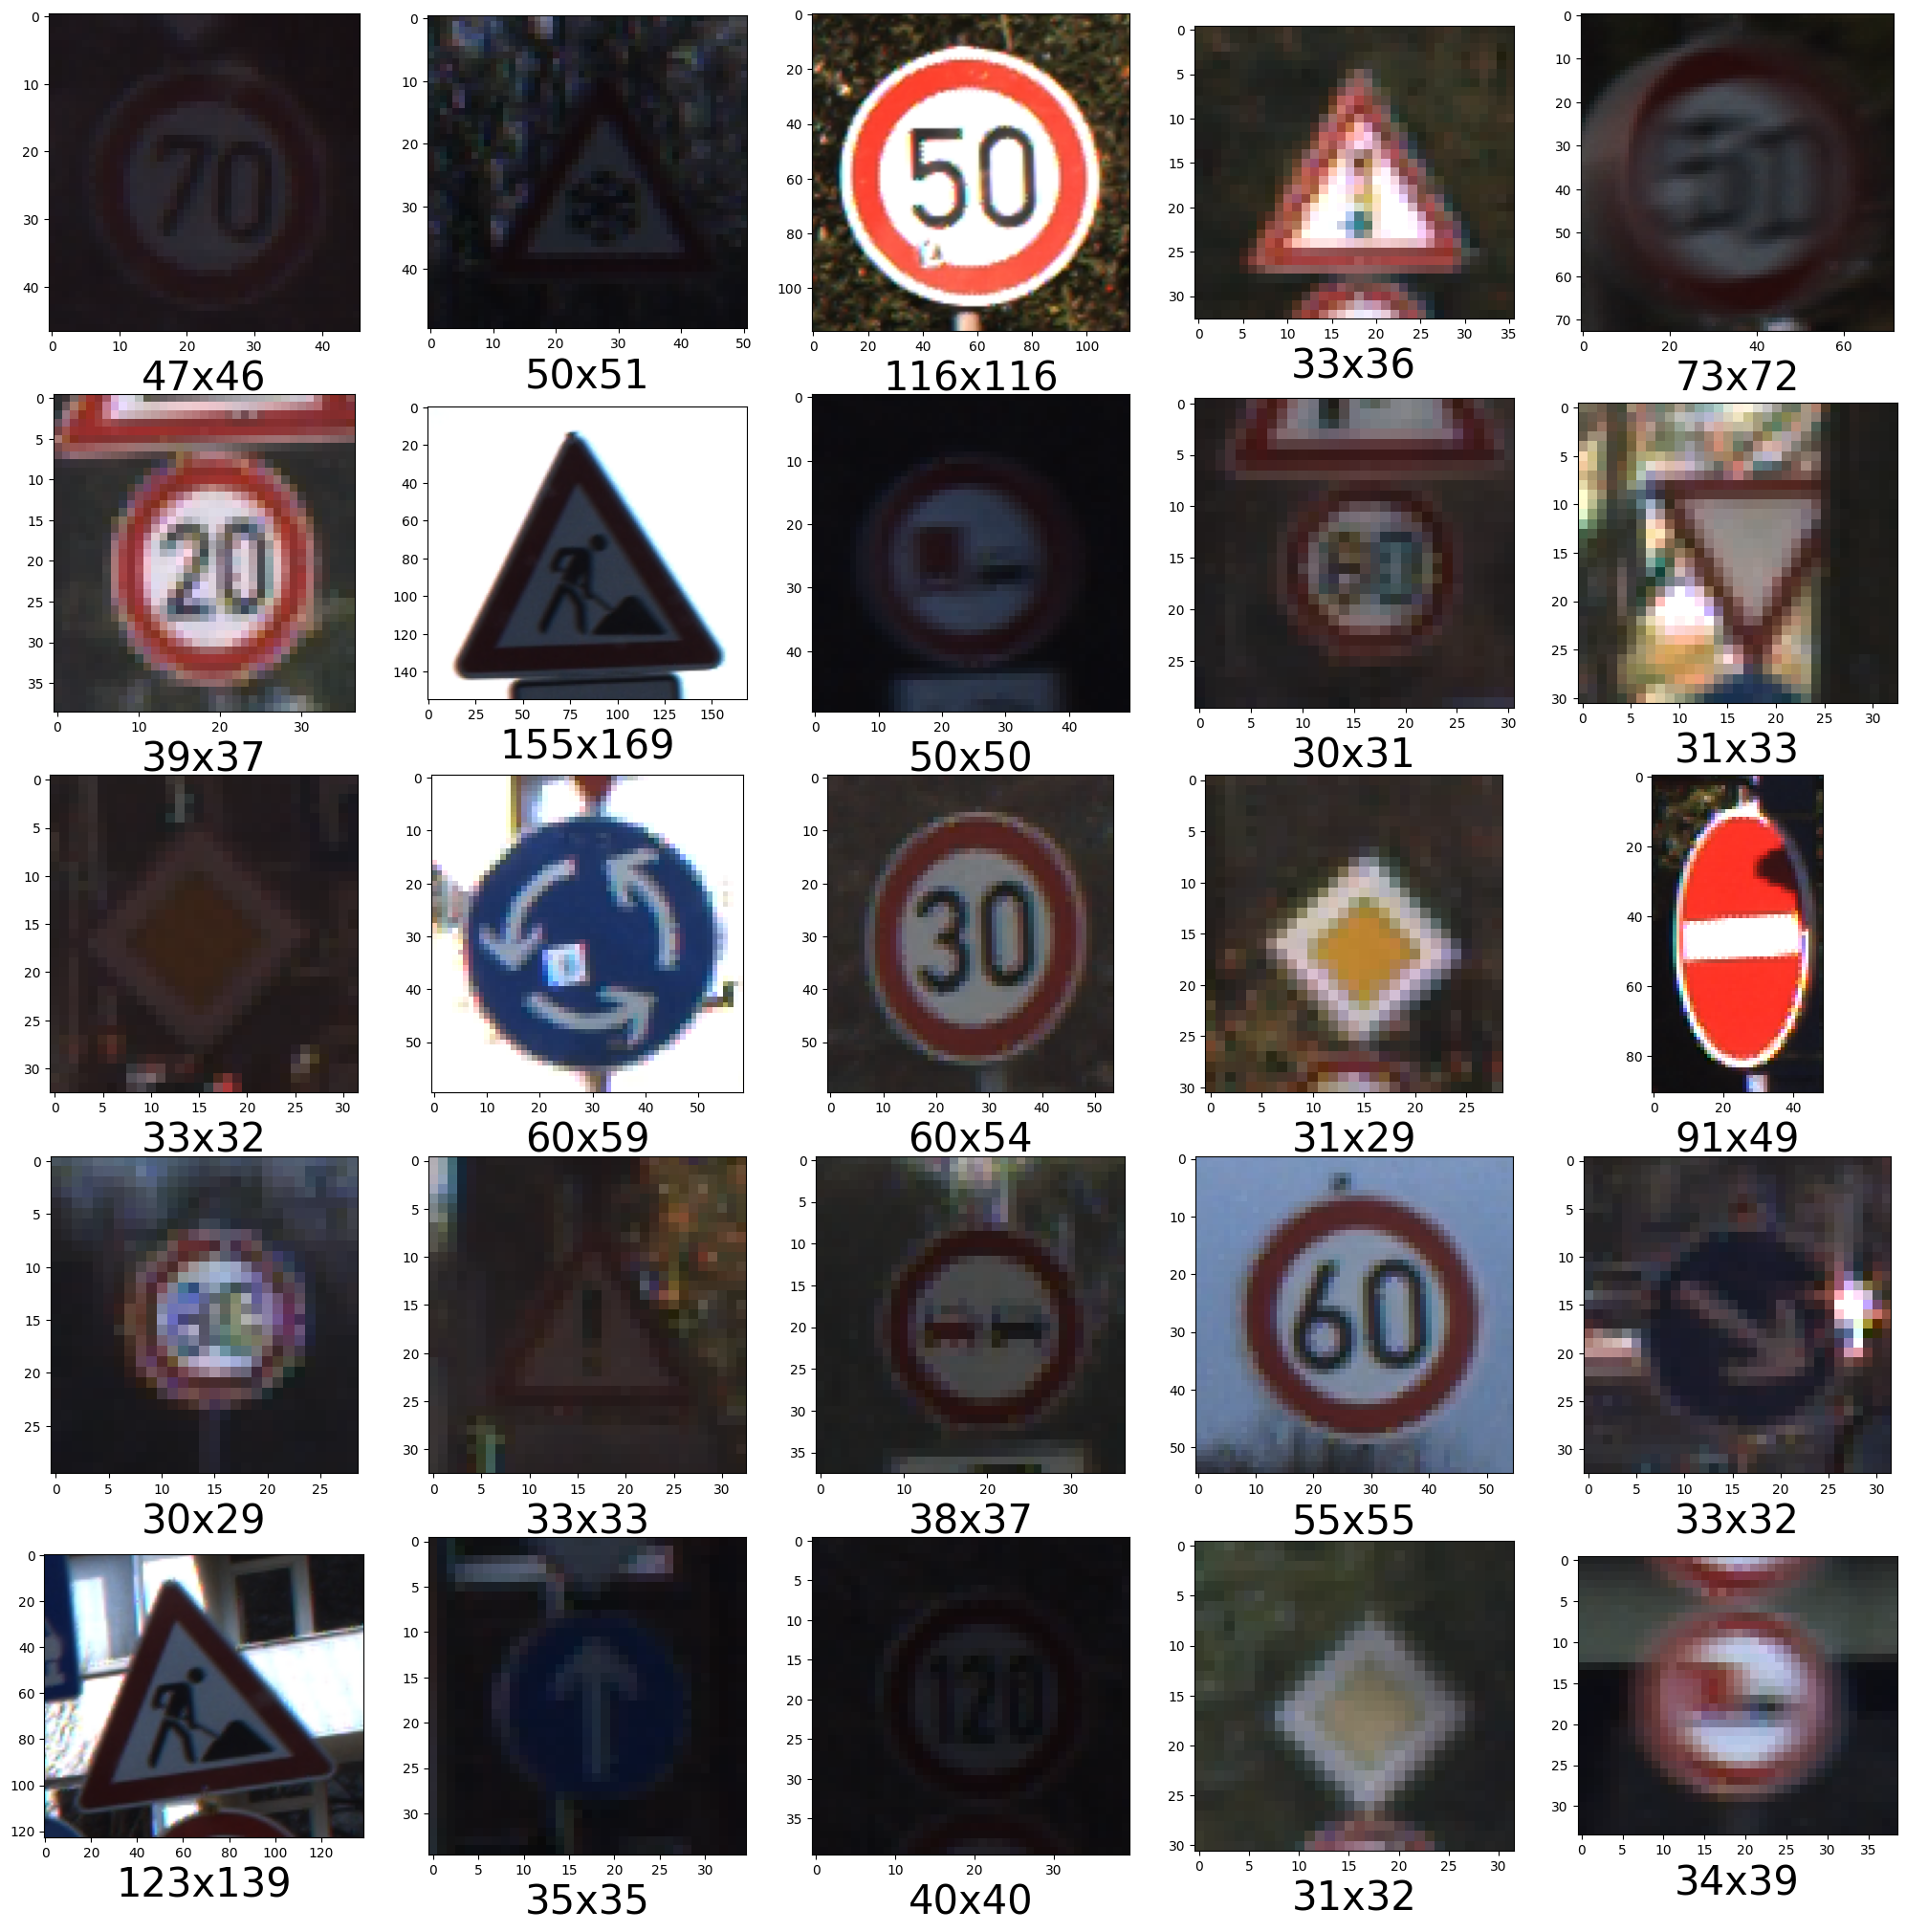

In [22]:
# Visualizing 25 random images from test data

test = pd.read_csv(data_dir + "/Test.csv")
test_img_names = test["Path"].values
test_imgs = []

for i in range(25):
    test_imgs.append(imread(os.path.join(data_dir, random.choice(test_img_names))))


def show_imgs(imgs, size, n):
    plt.figure(figsize=size)
    for i, img in enumerate(imgs):
        plt.subplot(n, n, i + 1)
        plt.imshow(img)
        plt.grid(visible=False)
        plt.xlabel(
            "{}x{}".format(img.shape[0], img.shape[1]), fontsize=30
        )  # height x width


show_imgs(test_imgs, (25, 25), 5)

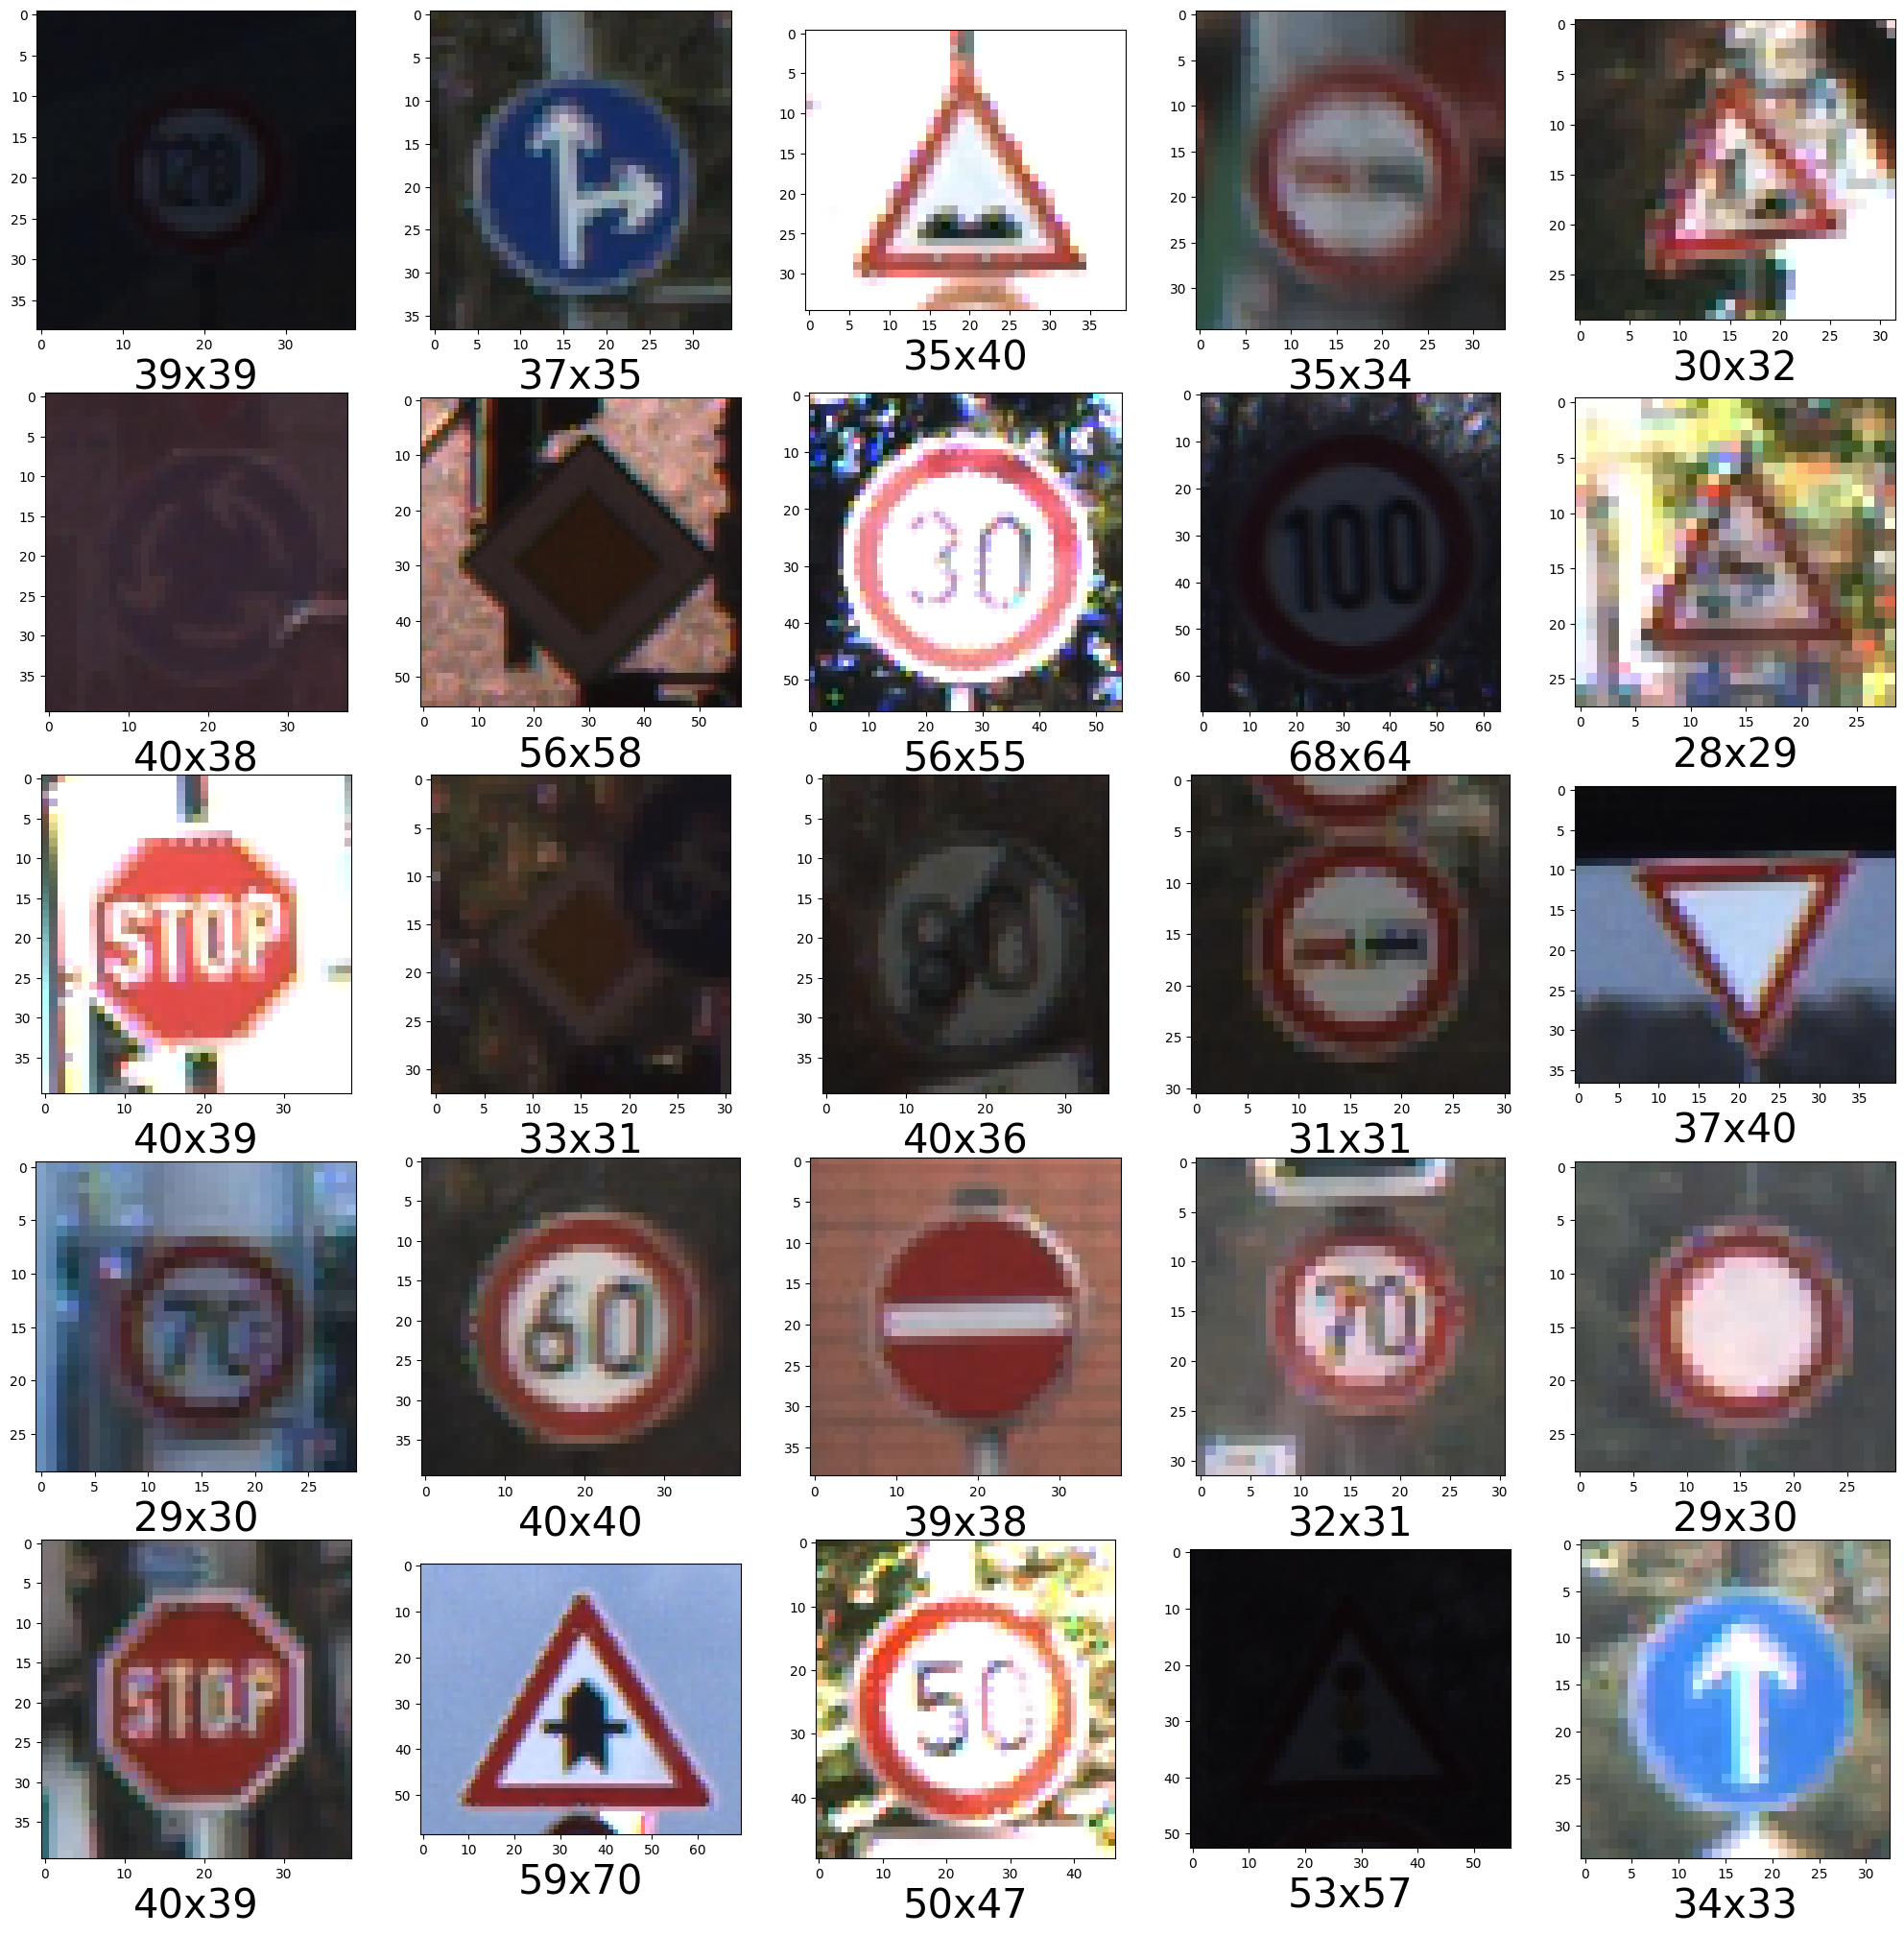

In [23]:
# Visualizing Raw train data before preprocessing
train_data = pd.read_csv(data_dir + "/Train.csv")
train_img_names = train_data["Path"].values
train_imgs = []
for i in range(25):
    train_imgs.append(imread(os.path.join(data_dir, random.choice(train_img_names))))
show_imgs(train_imgs, (25, 25), 5)

## Collecting and preprocessing the Training Data 

In [24]:
def collect_and_preprocess_data(csv_file):
    imgs = []
    labels  = []
    info_csv = pd.read_csv(f"{data_dir}/{csv_file}")
    for row in info_csv.iterrows():
        try:
            img_path = f"{data_dir}/{row[1].Path}"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # work with matplotlib imshow()
            x1, y1, x2, y2 = row[1]["Roi.X1"],row[1]["Roi.Y1"], row[1]["Roi.X2"],row[1]["Roi.Y2"]
            img = img[y1: y2, x1: x2]
            img = cv2.resize(img ,(IMG_HEIGHT, IMG_WIDTH))
            imgs.append(np.array(img))
            labels.append(row[1].ClassId)
        except Exception:
            print(f"Error in {img_path}")
            traceback.print_exc()
            return
    imgs = np.array(imgs)
    labels= np.array(labels)
    return imgs, labels

# Changing the list to numpy array
image_data, image_labels = collect_and_preprocess_data("Train.csv")

print(image_data.shape, image_labels.shape)

(39209, 30, 30, 3) (39209,)


## Shuffling the training data

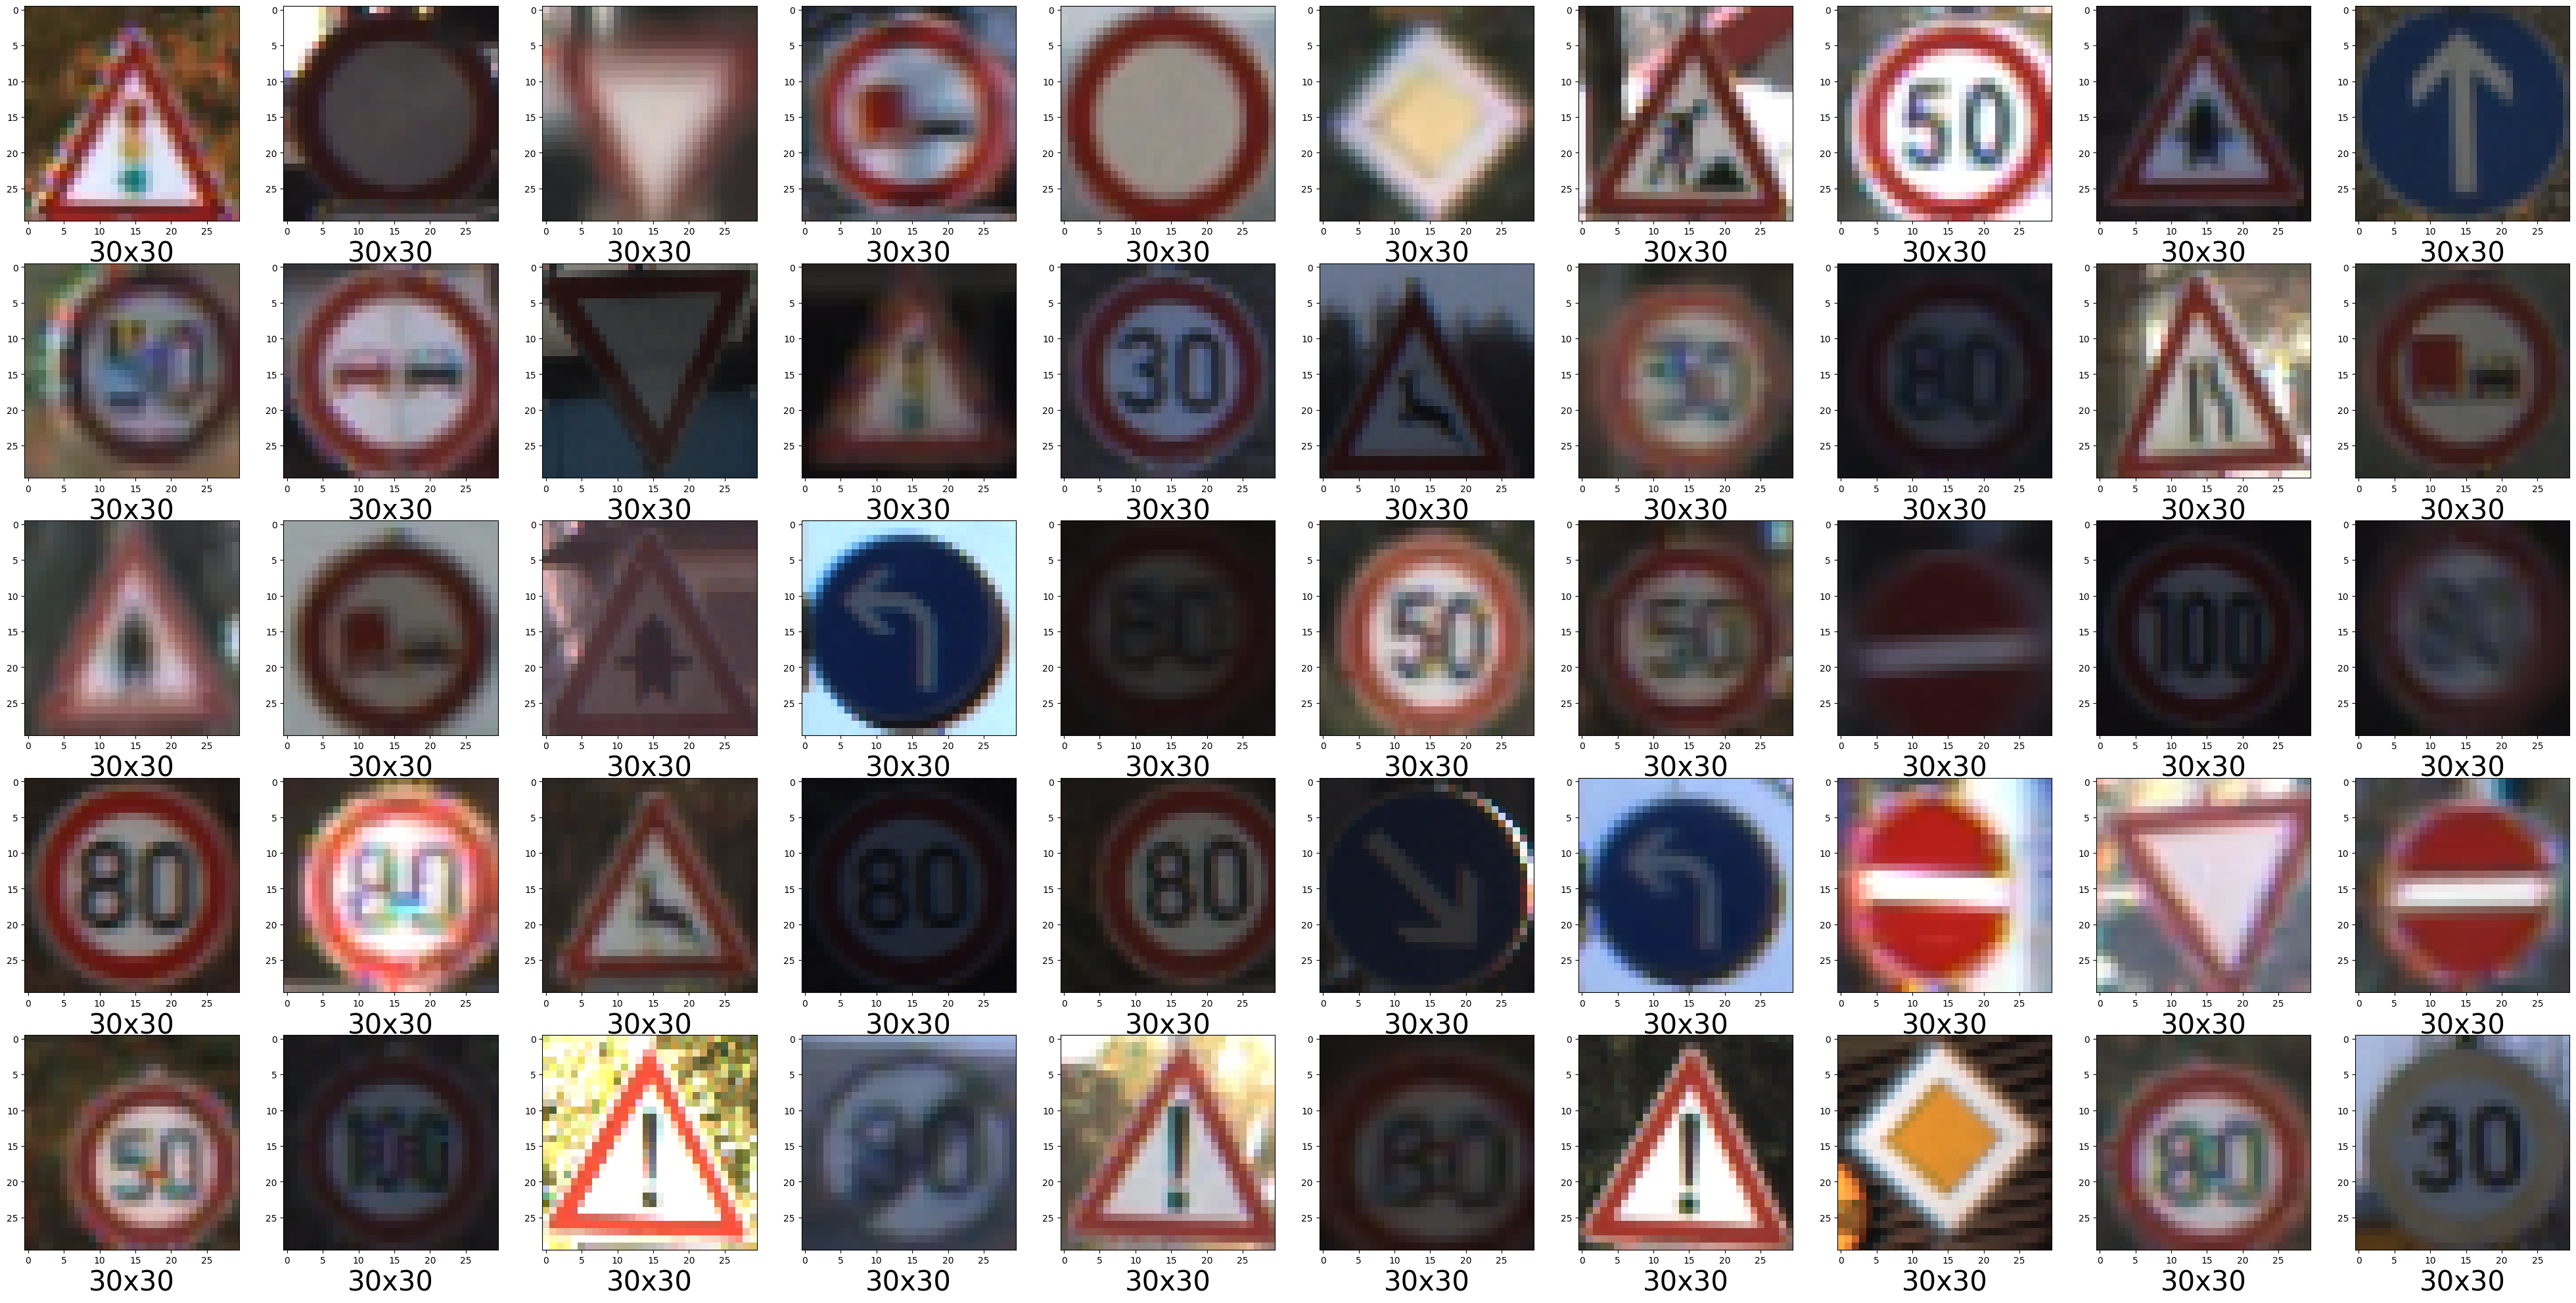

In [25]:
shuffle_indexes = np.arange(image_data.shape[0])
np.random.shuffle(shuffle_indexes)
image_data = image_data[shuffle_indexes]
image_labels = image_labels[shuffle_indexes]
show_imgs(image_data[0:50], (50, 50), 10)

## Splitting the data into train and validation set

In [26]:
X_train, X_val, y_train, y_val = train_test_split(image_data, image_labels, test_size=0.3, random_state=42, shuffle=True)

X_train = X_train/255 
X_val = X_val/255

print("X_train.shape", X_train.shape)
print("X_valid.shape", X_val.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_val.shape)

X_train.shape (27446, 30, 30, 3)
X_valid.shape (11763, 30, 30, 3)
y_train.shape (27446,)
y_valid.shape (11763,)


In [27]:
# cv2.imshow("img ",X_train[0,:,:,0])
# cv2.waitkey(0)
X_train[0,:,:,0]

array([[0.07843137, 0.07843137, 0.09019608, 0.10588235, 0.10980392,
        0.27843137, 0.34117647, 0.33333333, 0.30588235, 0.27058824,
        0.24313725, 0.21960784, 0.20784314, 0.21960784, 0.22352941,
        0.23137255, 0.25882353, 0.29411765, 0.30980392, 0.30588235,
        0.27843137, 0.21568627, 0.13333333, 0.09411765, 0.08627451,
        0.09019608, 0.07843137, 0.09019608, 0.09019608, 0.07843137],
       [0.0745098 , 0.07843137, 0.09803922, 0.12941176, 0.15686275,
        0.23137255, 0.26666667, 0.26666667, 0.23921569, 0.23137255,
        0.20784314, 0.19215686, 0.19215686, 0.2       , 0.20392157,
        0.20784314, 0.21568627, 0.23137255, 0.23137255, 0.22352941,
        0.21568627, 0.19607843, 0.1372549 , 0.11372549, 0.10980392,
        0.10980392, 0.10196078, 0.09803922, 0.09411765, 0.08235294],
       [0.07843137, 0.08235294, 0.12941176, 0.2       , 0.22745098,
        0.21176471, 0.19215686, 0.17647059, 0.16862745, 0.18039216,
        0.16862745, 0.15686275, 0.16078431, 0.

## One hot encoding the labels

In [28]:
y_train = keras.utils.to_categorical(y_train, NUM_CATEGORIES)
y_val = keras.utils.to_categorical(y_val, NUM_CATEGORIES)

print(y_train.shape)
print(y_val.shape)

(27446, 43)
(11763, 43)


# Determine important values

In [29]:
# kernel_sizes = [(3, 3), (5, 5)]
kernel_sizes = [(3,3)] # (5,5) is worse due to experiment
n_filters = [16, 32, 64]
# dropout_rates = [0.2, 0.3, 0.4, 0.5]
dropout_rates = [0.4, 0.5] # 0.4 and 0.5 is better

In [31]:
sequentials = []
models_info = []
def create_seq(base_filters, kernel_size, drop_rate, strides=None, pool_size = (2,2),  activation_function = "relu", padding="valid"):
    seq = [
        Conv2D(
            filters=base_filters,
            kernel_size=kernel_size,
            activation="relu",
            input_shape=(IMG_HEIGHT, IMG_WIDTH, channels),
            padding=padding
        ),
        Conv2D(filters=base_filters*2, kernel_size=kernel_size, activation=activation_function,padding=padding),
        MaxPool2D(pool_size=pool_size, strides=strides),
        BatchNormalization(axis=-1),
        Conv2D(filters=base_filters*4, kernel_size=kernel_size, activation=activation_function, padding=padding),
        Conv2D(filters=base_filters*8, kernel_size=kernel_size, activation=activation_function, padding=padding),
        MaxPool2D(pool_size=pool_size, strides=strides),
        BatchNormalization(axis=-1),
        Flatten(),
        Dense(base_filters*8*4, activation="relu"),
        BatchNormalization(),
        Dropout(rate=drop_rate),
        Dense(43, activation="softmax"),
    ]
    return seq

for ks in kernel_sizes:
    for nf in n_filters:
        for dr in dropout_rates:
            sequentials.append(create_seq(nf, ks, dr))
            models_info.append([ks, nf, dr])

## Making the model

In [32]:
epochs = 11
batch_size = 32
train_size = len(y_train)

def adam_with_decay_lr(initial_learning_rate, final_learning_rate):
    learning_rate_decay_factor = (final_learning_rate / initial_learning_rate)**(1/epochs)
    steps_per_epoch = int(train_size/batch_size)
    lr_schedule = schedules.ExponentialDecay(
                    initial_learning_rate=initial_learning_rate,
                    decay_steps=steps_per_epoch,
                    decay_rate=learning_rate_decay_factor,
                    staircase=True)

    opt = Adam(learning_rate=lr_schedule)
    return opt


models = []

for pred in sequentials:
    opt = adam_with_decay_lr(0.001, 0.000001)
    model = Sequential(pred)
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
    models.append(model)

## Augmenting the data and training the model

We create an augmentation of each image. To illustrate, look at the pictures below (number 0, 1, 2, ... are timestamps), the augmentation flow will create many different image base on the original one.

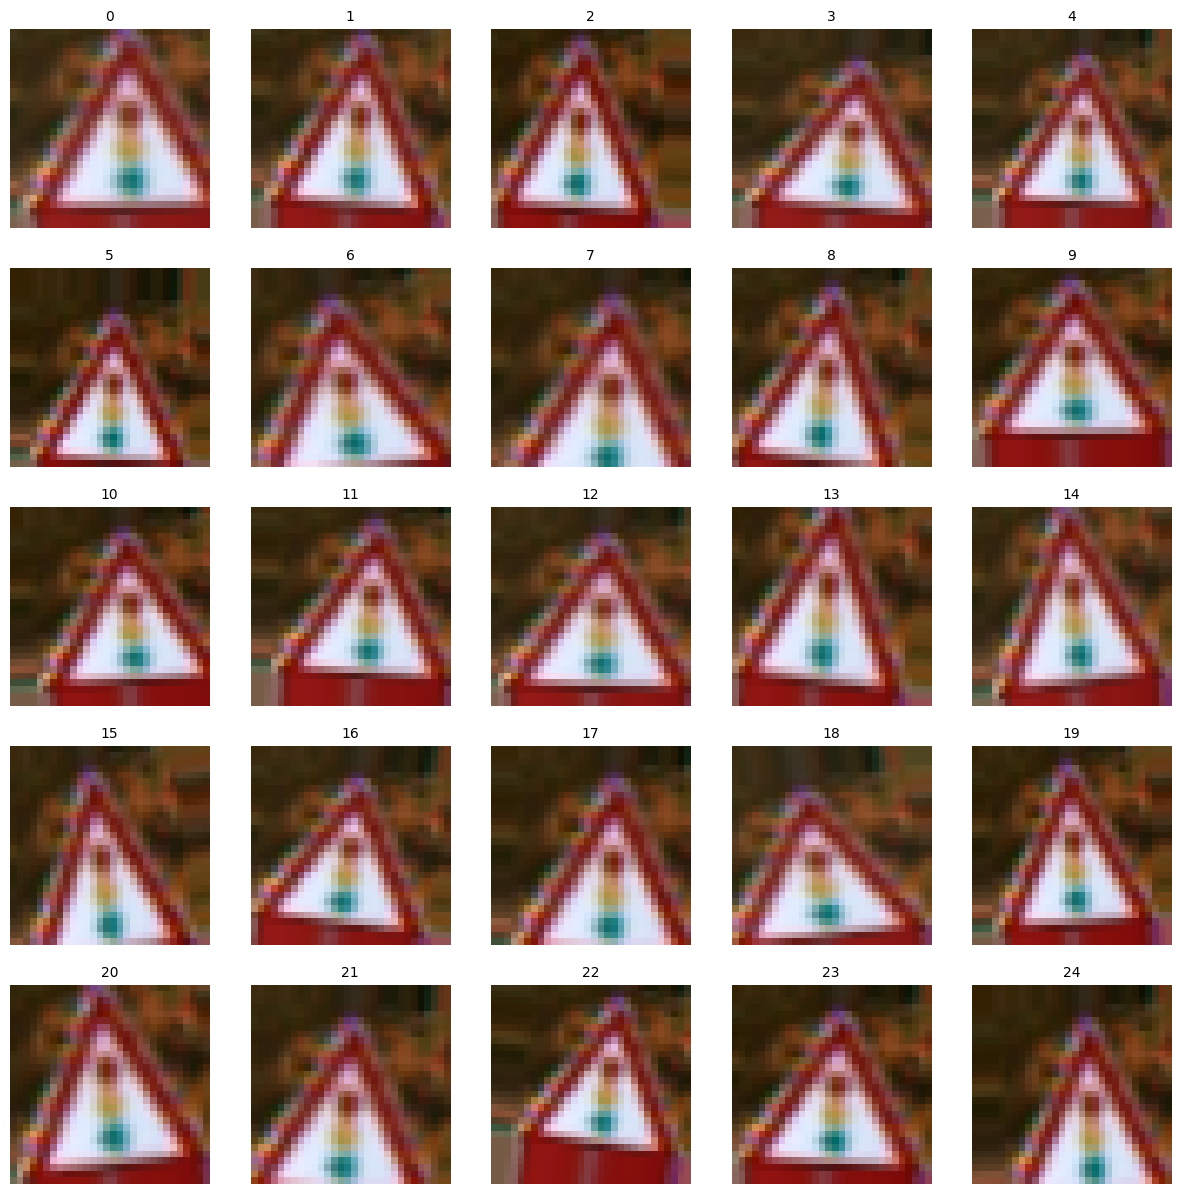

In [33]:
from keras.preprocessing.image import array_to_img, img_to_array 

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest",
)


def illustrate_aug():
    # Load and preprocess an example image
    x = img_to_array(image_data[0])
    x = x.reshape((1,) + x.shape)

    # Generate augmented images
    num_augmented_images = 25
    fig, axes = plt.subplots(ncols=5, nrows=5, figsize=(15, 15))

    for i in range(5):
        for j in range(5):
            augmented_image = array_to_img(aug.flow(x, batch_size=batch_size)[0][0])
            axes[i, j].imshow(augmented_image)
            axes[i, j].axis("off")
            axes[i, j].set_title(f"{i*5 + j}", fontsize=10)

        if i == num_augmented_images:
            break

    plt.show()

illustrate_aug()

In [ ]:
histories = []
for i, m in enumerate(models):
    print(f"Train model with kernel_size={models_info[i][0]} filters={models_info[i][1]} drop_rate={models_info[i][2]}")
    history = m.fit(aug.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val))
    histories.append(history)

## Evaluating the model

In [35]:
for h in histories:
    pd.DataFrame(h.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.title(f"{h.model.layers[0].filters}_{h.model.layers[0].kernel_size}_{h.model.layers[-2].rate}")
    plt.gca().set_ylim(0, 1)
    plt.show()

## Loading the test data and running the predictions

In [ ]:
X_test, labels = collect_and_preprocess_data("Test.csv")
X_test = X_test/255

predictions = []
results = []


print("Accuracy in Test Data:")
for i, model in enumerate(models):
    pred = np.argmax(model.predict(X_test),axis=1) 
    predictions.append(pred)
    model_accuracy = accuracy_score(labels, pred)
    print(f'kernel_size={models_info[i][0]} filters={models_info[i][1]} drop_rate={models_info[i][2]}: {model_accuracy*100}')
    results.append(model_accuracy)

best_model_id = np.argmax(results)
print(models_info[best_model_id])


# Test with padding same

In [37]:
seq_with_padding = create_seq(32, (3,3), 0.4, padding="same")
models_with_padding = Sequential(seq_with_padding)
models_with_padding.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
models_with_padding.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 30, 30, 32)        896       
                                                                 
 conv2d_25 (Conv2D)          (None, 30, 30, 64)        18496     
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 15, 15, 64)        0         
 ng2D)                                                           
                                                                 
 batch_normalization_18 (Ba  (None, 15, 15, 64)        256       
 tchNormalization)                                               
                                                                 
 conv2d_26 (Conv2D)          (None, 15, 15, 128)       73856     
                                                                 
 conv2d_27 (Conv2D)          (None, 15, 15, 256)      

In [38]:
history_of_models_with_padding = models_with_padding.fit(aug.flow(X_train, y_train, batch_size=batch_size), epochs=epochs, validation_data=(X_val, y_val))

Epoch 1/11
858/858 [==============================] - 153s 176ms/step - loss: 0.6634 - accuracy: 0.8249 - val_loss: 0.0733 - val_accuracy: 0.9786
Epoch 2/11
858/858 [==============================] - 156s 182ms/step - loss: 0.0533 - accuracy: 0.9843 - val_loss: 0.0116 - val_accuracy: 0.9967
Epoch 3/11
858/858 [==============================] - 156s 182ms/step - loss: 0.0258 - accuracy: 0.9923 - val_loss: 0.0056 - val_accuracy: 0.9983
Epoch 4/11
858/858 [==============================] - 155s 180ms/step - loss: 0.0146 - accuracy: 0.9961 - val_loss: 0.0030 - val_accuracy: 0.9992
Epoch 5/11
858/858 [==============================] - 156s 182ms/step - loss: 0.0099 - accuracy: 0.9977 - val_loss: 0.0026 - val_accuracy: 0.9994
Epoch 6/11
858/858 [==============================] - 157s 183ms/step - loss: 0.0078 - accuracy: 0.9978 - val_loss: 0.0021 - val_accuracy: 0.9994
Epoch 7/11
858/858 [==============================] - 156s 181ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0021 -

In [41]:
pred_wp = np.argmax(models_with_padding.predict(X_test),axis=1) 
model_wp_accuracy = accuracy_score(labels, pred_wp)
print(model_wp_accuracy*100)

395/395 [==============================] - 12s 31ms/step
98.90736342042756


# Test with strides, pool_size

# Test with another activation functions

## Visualizing the confusion matrix

In [20]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(labels, predictions[0])

<Axes: >

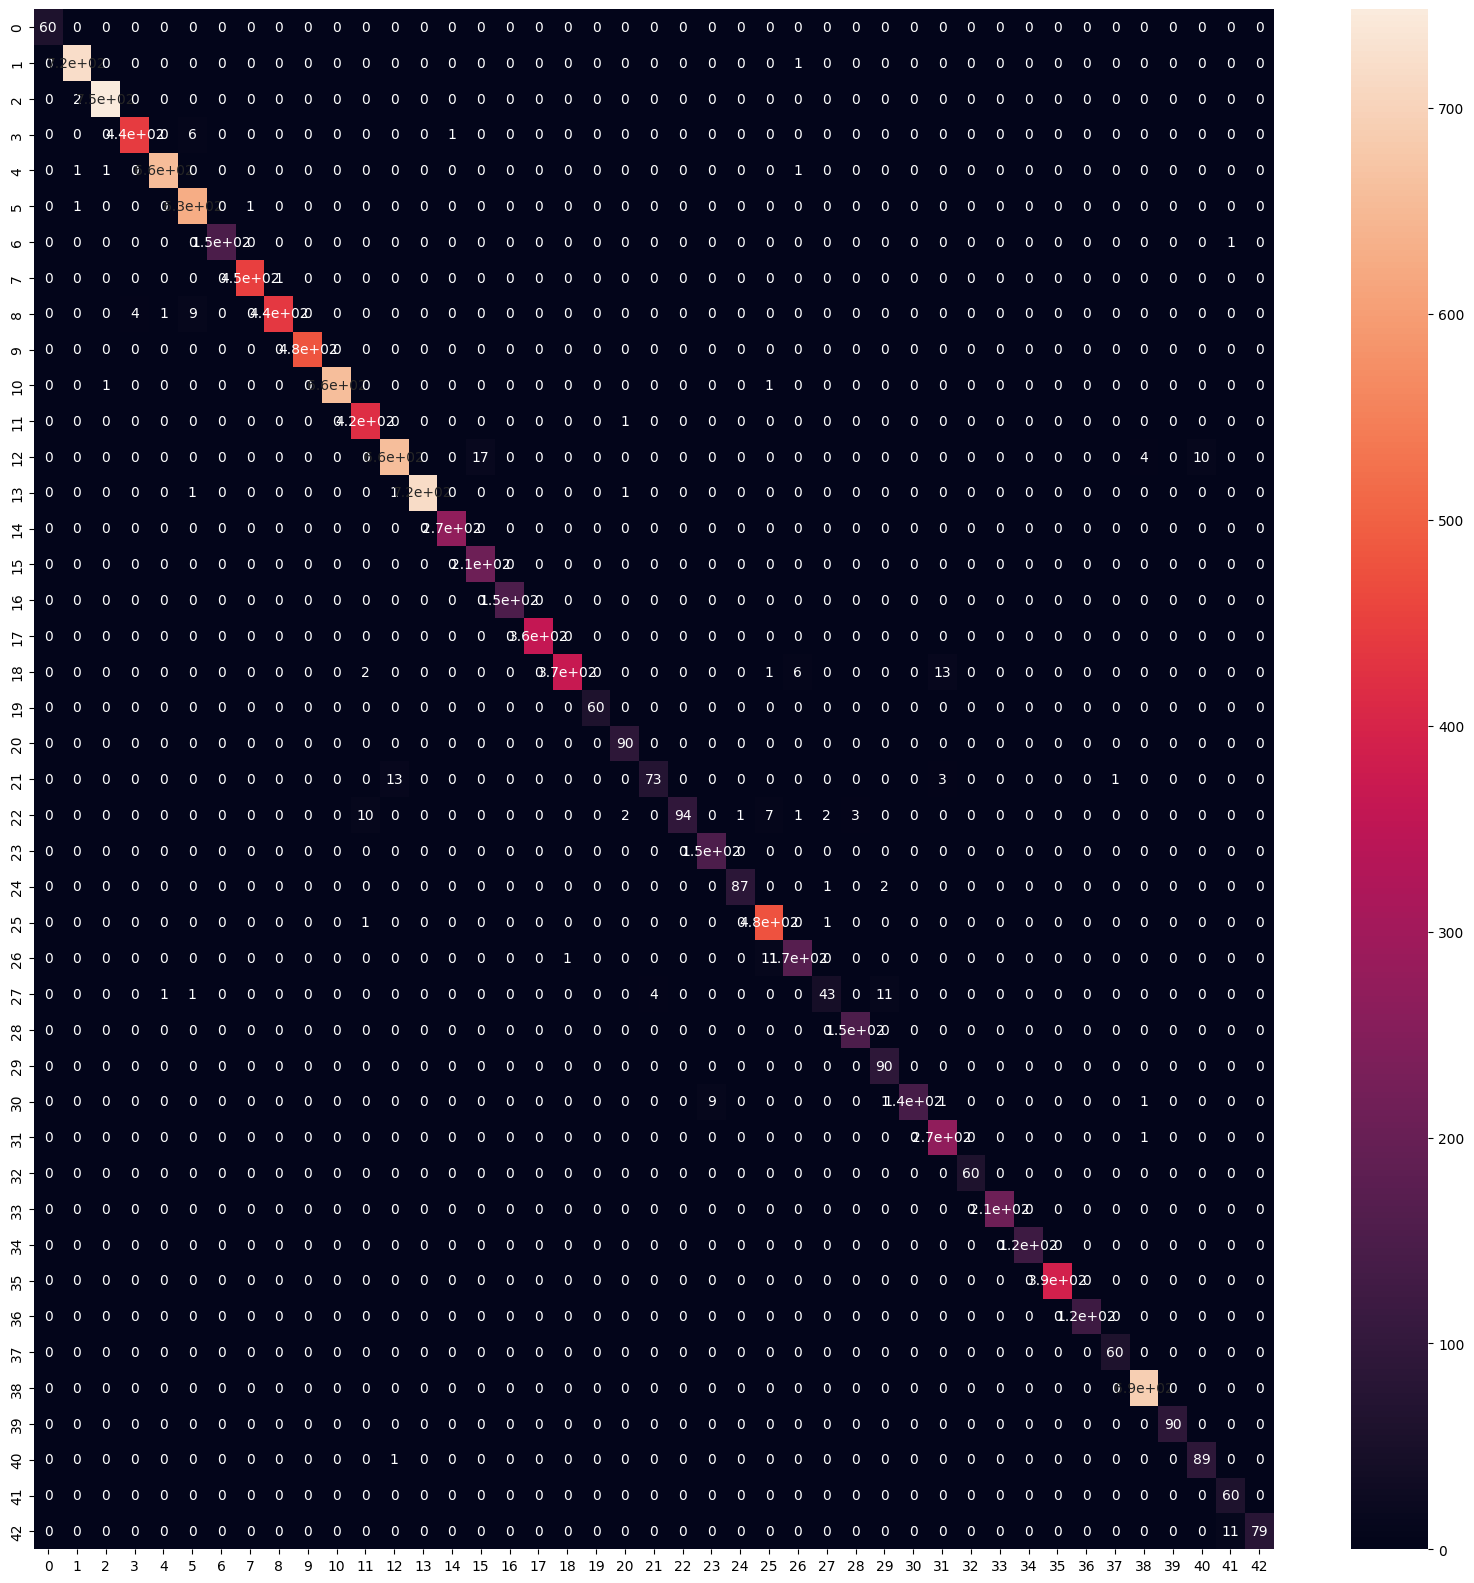

In [21]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (20,20))
sns.heatmap(df_cm, annot=True)

## Classification report

In [22]:
from sklearn.metrics import classification_report

for pred in predictions:
    print(classification_report(labels, pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.99      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       0.99      0.98      0.99       450
           4       1.00      1.00      1.00       660
           5       0.97      1.00      0.99       630
           6       1.00      0.99      1.00       150
           7       1.00      1.00      1.00       450
           8       1.00      0.97      0.98       450
           9       1.00      1.00      1.00       480
          10       1.00      1.00      1.00       660
          11       0.97      1.00      0.98       420
          12       0.98      0.96      0.97       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.93      1.00      0.96       210
          16       1.00      1.00      1.00       150
          17       1.00    

## Predictions on Test Data

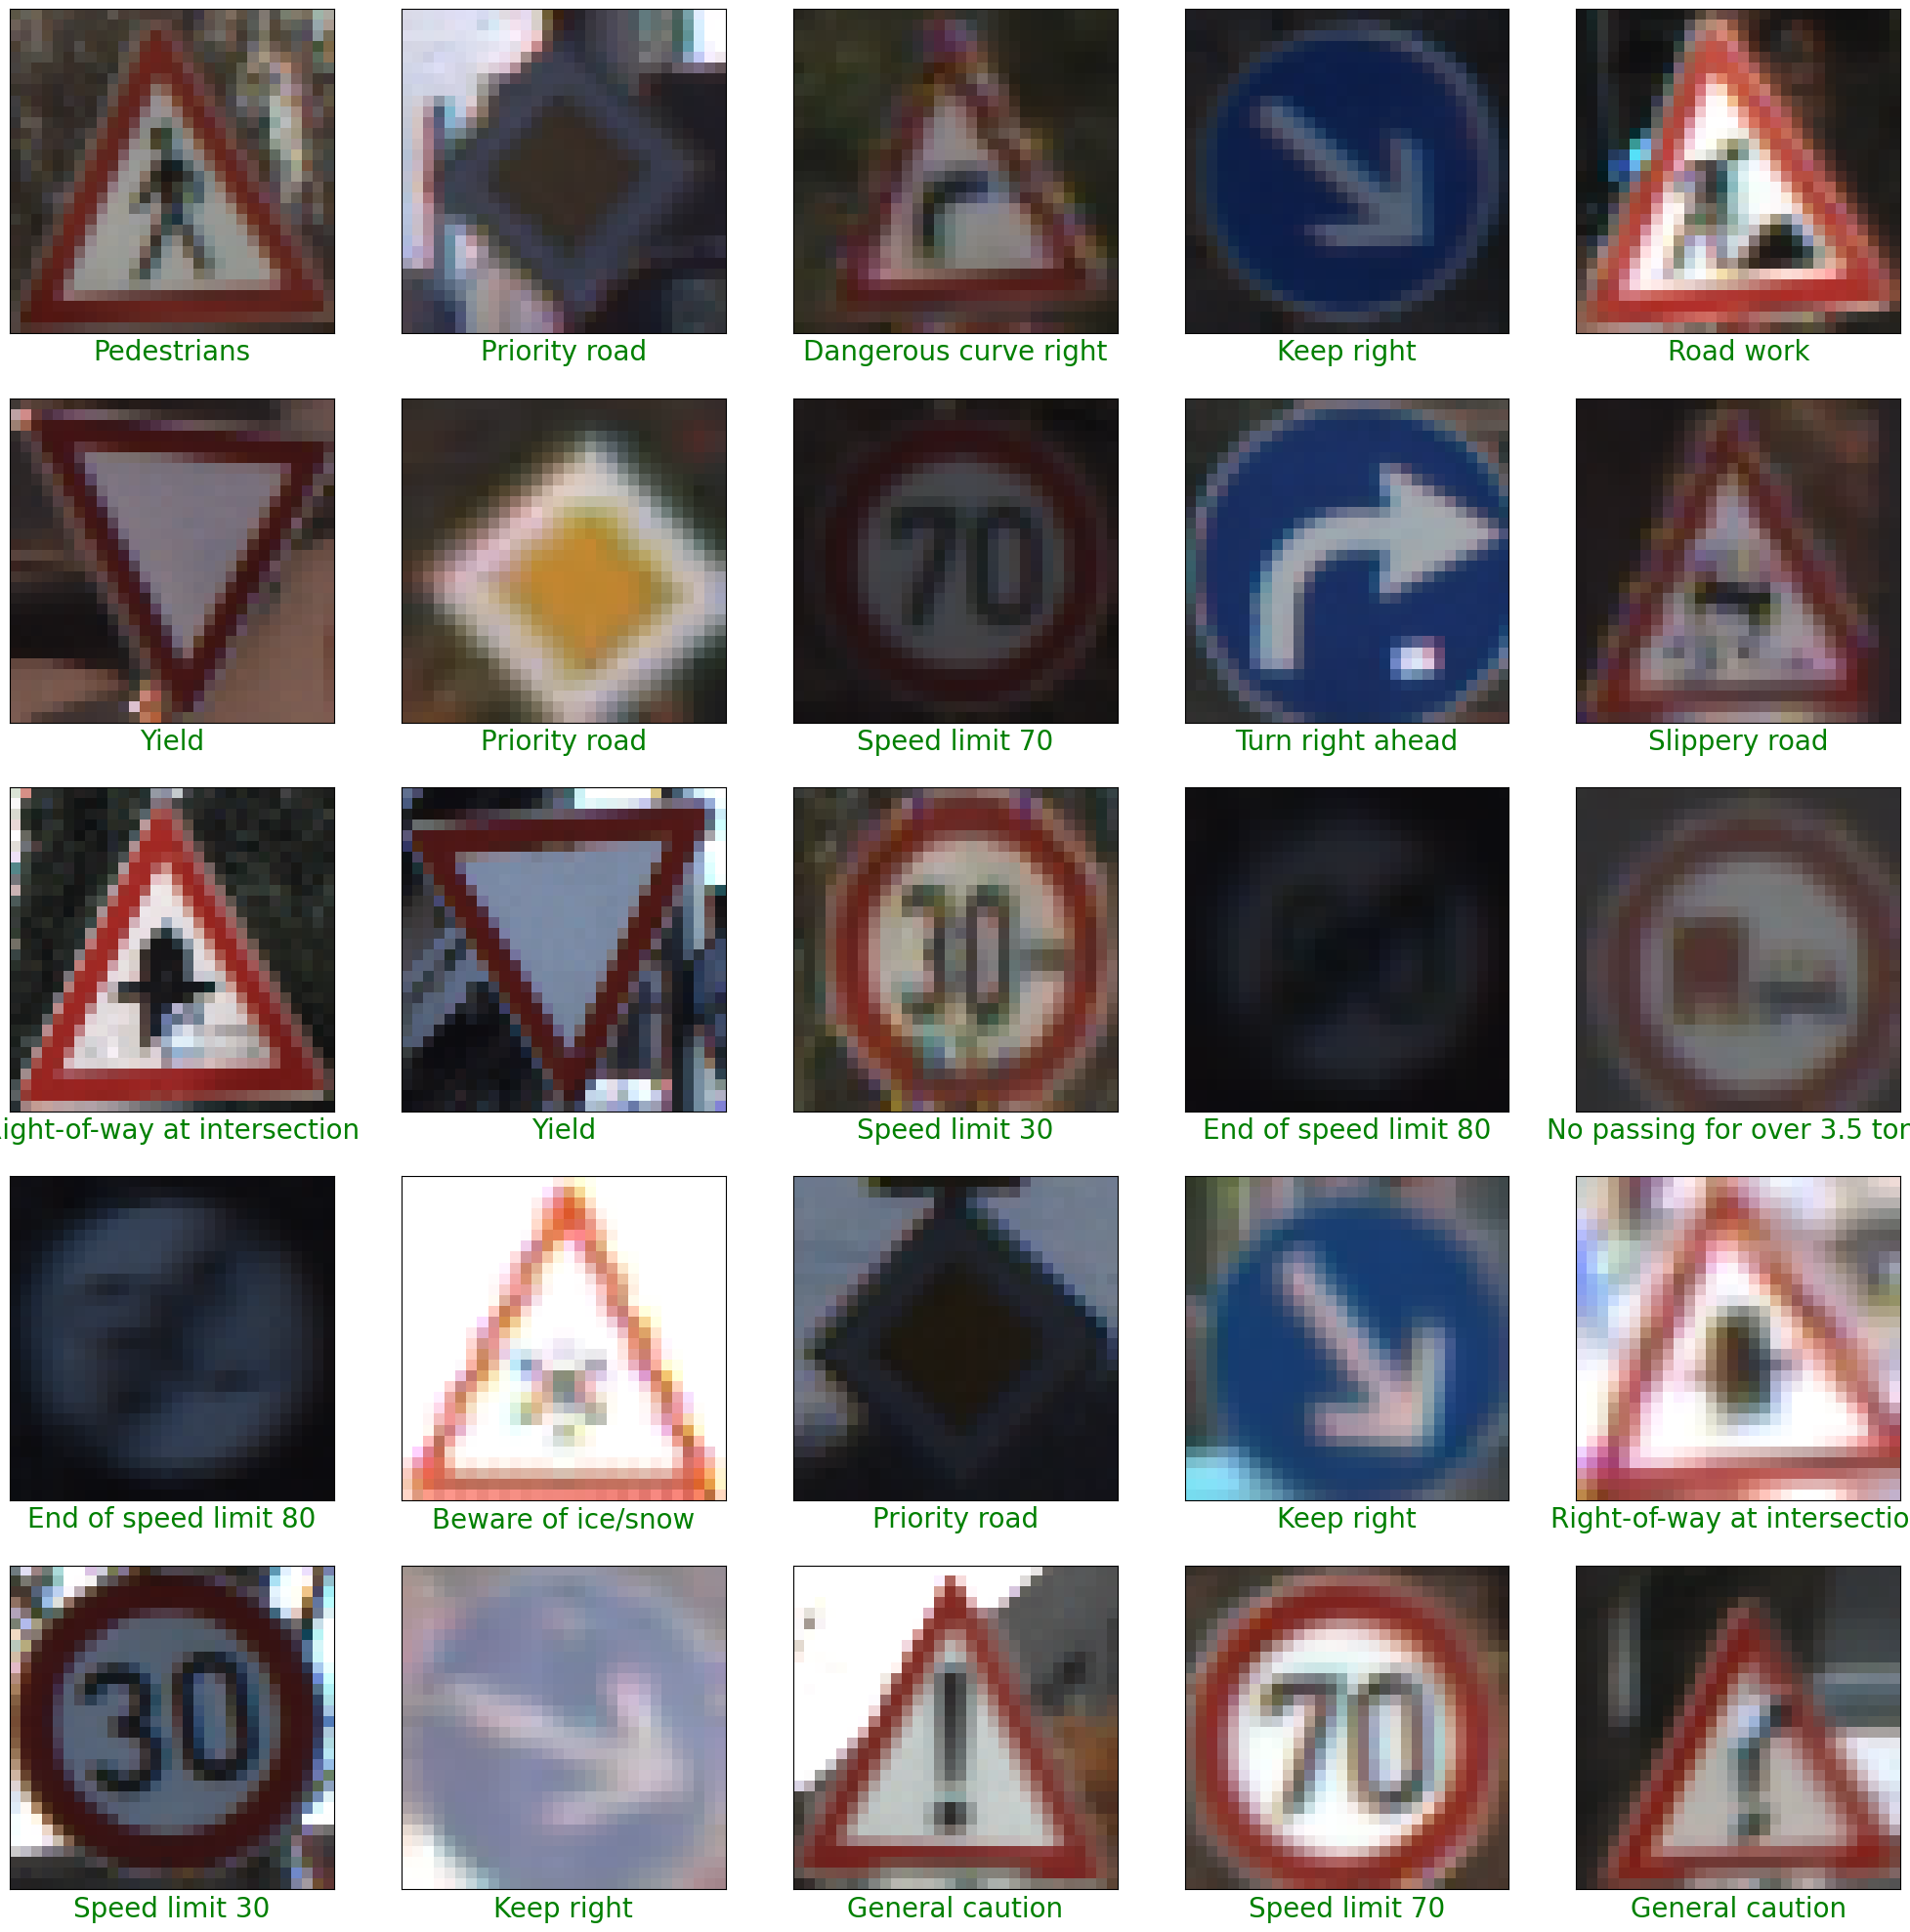

In [23]:
plt.figure(figsize = (25, 25))

start_index = 10000
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    pred = predictions[best_model_id][start_index + i]
    actual = labels[start_index + i]
    col = 'g'
    if pred != actual:
        col = 'r'
    plt.xlabel('{}'.format(classes[pred]), color = col, fontsize=20)
    plt.imshow(X_test[start_index + i])
plt.show()

# Save model

In [26]:
final_model_filename = f"final_model_{models_info[best_model_id][0]}_{models_info[best_model_id][1]}_{models_info[best_model_id][2]}.keras"
models[best_model_id].save(final_model_filename)

# Test the saving model

In [27]:
def test_saving_model(path):
    reconstructed_model = keras.saving.load_model(path)
    predict_x=reconstructed_model.predict(X_test) # return a 2D array
    result = np.argmax(predict_x,axis=1) # Max index of each rows
    print("Accuracy: ",accuracy_score(labels, result)*100)

test_saving_model(final_model_filename)

395/395 [==============================] - 22s 55ms/step
Accuracy:  98.95486935866984


1/1 [==============================] - 0s 141ms/step


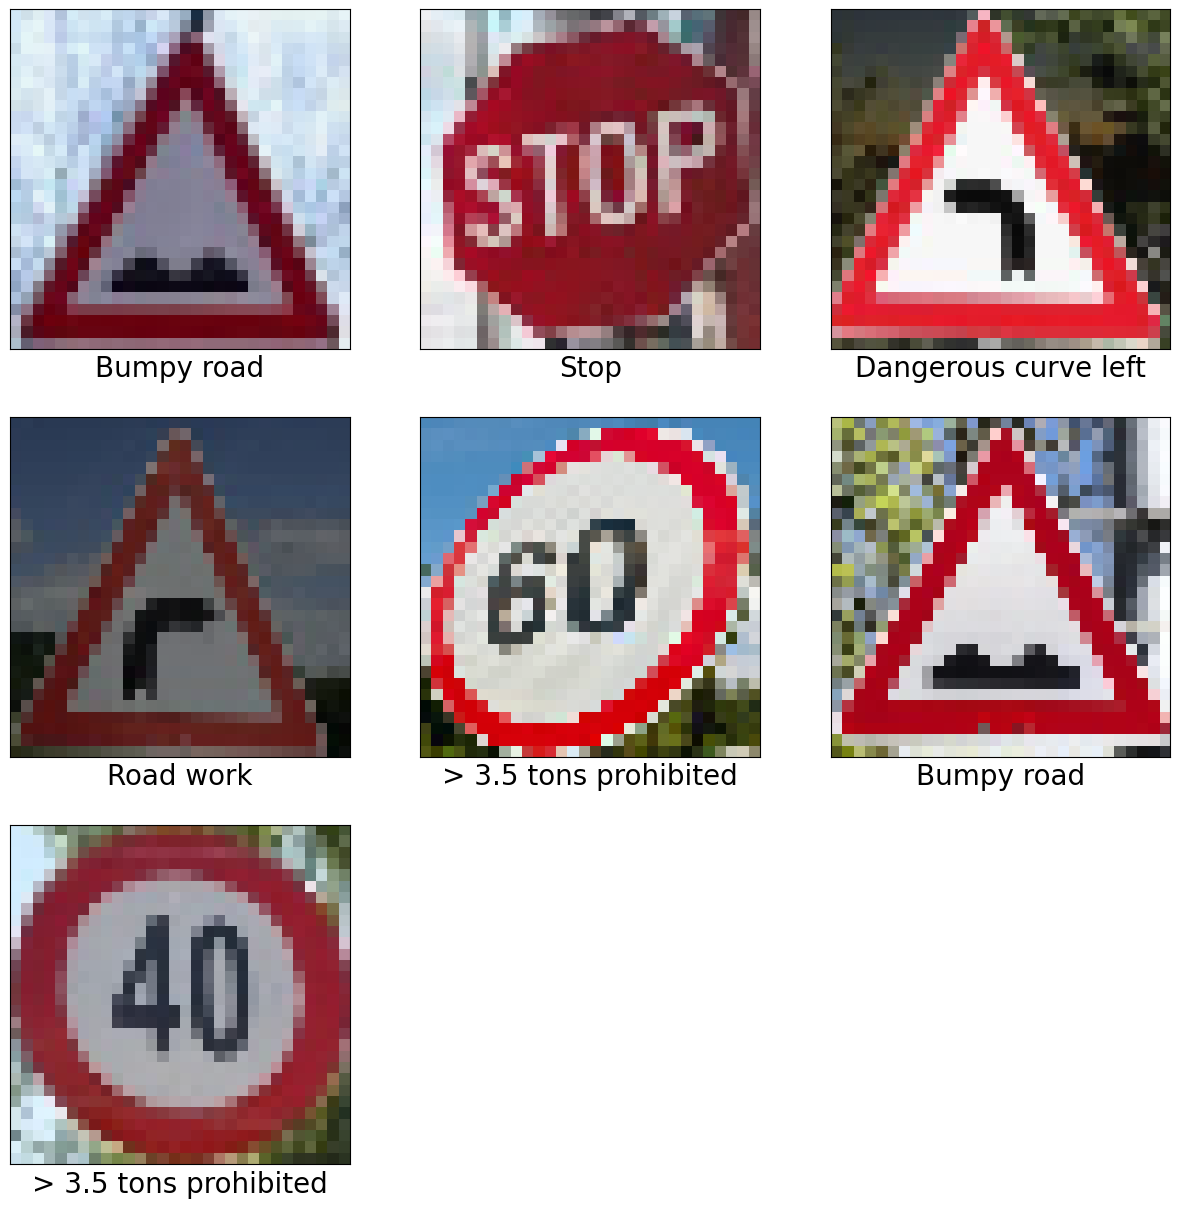

In [64]:
extra_test_imgs = []

for filename in os.listdir("extra_test"):
    img = cv2.imread(f"extra_test/{filename}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (30, 30))
    extra_test_imgs.append(np.array(img))

extra_test_imgs = np.array(extra_test_imgs)

def test_with_custom_img(imgs, model_path):
    reconstructed_model = keras.saving.load_model(model_path)
    predict_x=reconstructed_model.predict(imgs) # return a 2D array
    results = np.argmax(predict_x,axis=1) # Max index of each rows
    plt.figure(figsize=(15, 15))
    for i, res in enumerate(results):
        plt.subplot(3, 3, i + 1)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('{}'.format(classes[res]), fontsize=20)
        plt.imshow(imgs[i])

test_with_custom_img(extra_test_imgs, final_model_filename)
